# Semantic Segmentation with Enhanced MRF and Context Features


## Optimized Notebook for MSRC v2 Dataset

This notebook implements semantic segmentation using:- **Superpixel-based feature extraction** with SLIC- **Advanced MRF parameter tuning** with adaptive λ and σ- **Enhanced context features** from neighboring superpixels- **Class imbalance mitigation** strategies

# Chapter 0: Dependencies and Setup

This chapter contains:- 0.1 Library Imports- 0.2 Configuration Constants- 0.3 Helper Function Definitions

## 0.1 Library Imports

In [2]:
# Core Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import time
import warnings
warnings.filterwarnings('ignore')
# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
# Image Processing Libraries
from skimage.segmentation import slic, mark_boundaries
from skimage import color as skcolor
from skimage.color import label2rgb
from skimage import graph
from skimage.feature import graycomatrix, graycoprops
# Graph Cut / MRF Library
import maxflow
# Class Imbalance Handling
from scipy.ndimage import distance_transform_edt

## 0.2 Configuration Constants

In [3]:
# Dataset Configuration
DATASET_ROOT = "./dataset"
IMAGES_DIR = os.path.join(DATASET_ROOT, "images")
GT_DIR = os.path.join(DATASET_ROOT, "gt")
TRAIN_PATH = os.path.join(DATASET_ROOT, "Train.txt")
VALIDATION_PATH = os.path.join(DATASET_ROOT, "Validation.txt")
TEST_PATH = os.path.join(DATASET_ROOT, "Test.txt")
# Superpixel Configuration
SUPERPIXEL_TARGET_DENSITY = 0.006
SUPERPIXEL_COMPACTNESS = 10
SUPERPIXEL_SIGMA = 1
SUPERPIXEL_MIN_SEGMENTS = 100
SUPERPIXEL_MAX_SEGMENTS = 900
# MRF Configuration
MRF_BASE_LAMBDA = 0.5
MRF_BASE_SIGMA = 20.0
MRF_LAMBDA_RANGE = (5, 50)
MRF_SIGMA_RANGE = (10, 50)
# Scene type thresholds
SCENE_NATURAL_THRESHOLD = 0.70
SCENE_MANMADE_THRESHOLD = 0.70
# Feature Configuration
FEATURE_DIM_BASE = 16
FEATURE_DIM_CONTEXT = 32
FEATURE_DIM_SPATIAL = 6
# Class Imbalance Configuration
CLASS_WEIGHTS = None
FOCAL_LOSS_GAMMA = 2.0
DECISION_THRESHOLD = 0.5
# Evaluation Configuration
EVAL_SAMPLES = None
RANDOM_SEED = 5187

## 0.3 Helper Function Definitions

In [4]:
# Data Loading Helper Functions
def load_data_paths(txt_file, img_root, gt_root):
    """Read txt file and return full paths for images and GTs"""
    image_paths = []
    gt_paths = []
    
    if not os.path.exists(txt_file):
        print(f"Error: Index file {txt_file} not found")
        return [], []

    with open(txt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            filename = line.strip()
            if not filename: 
                continue
            
            if filename.lower().endswith('.bmp'):
                base_name = filename[:-4]
            elif filename.lower().endswith('.jpg'):
                base_name = filename[:-4]
            else:
                base_name = filename

            img_p = os.path.join(img_root, base_name + ".bmp")
            if not os.path.exists(img_p):
                img_p = os.path.join(img_root, base_name + ".jpg")
            
            gt_p = os.path.join(gt_root, base_name + "_GT.bmp")

            if os.path.exists(img_p) and os.path.exists(gt_p):
                image_paths.append(img_p)
                gt_paths.append(gt_p)

    return image_paths, gt_paths


def get_msrc_mapping():
    """Define color mapping for MSRC v2 dataset"""
    mapping = {}
    
    # Natural (0)
    mapping[(0, 128, 0)]     = 0  # Grass
    mapping[(0, 192, 0)]     = 0  # Grass Variant
    mapping[(128, 192, 128)] = 0  # Tree/Grass Light
    mapping[(0, 128, 128)]   = 0  # Tree
    mapping[(0, 64, 0)]      = 0  # Mountain
    mapping[(128, 128, 128)] = 0  # Sky
    mapping[(0, 0, 128)]     = 0  # Cow/Water
    mapping[(0, 128, 192)]   = 0  # Water
    mapping[(128, 128, 0)]   = 0  # Bird
    mapping[(0, 64, 128)]    = 0  # Sheep
    mapping[(64, 0, 128)]    = 0  # Cat
    mapping[(192, 128, 0)]   = 0  # Dog
    mapping[(64, 128, 0)]    = 0  # Horse
    mapping[(128, 0, 0)]     = 0  # Flower
    mapping[(192, 0, 0)]     = 0  # Flower Variant
    
    # Man-made (1)
    mapping[(128, 0, 128)]   = 1  # Building
    mapping[(192, 128, 128)] = 1  # Aeroplane
    mapping[(128, 64, 0)]    = 1  # Boat
    mapping[(128, 0, 64)]    = 1  # Body
    mapping[(192, 0, 128)]   = 1  # Bicycle
    mapping[(128, 64, 128)]  = 1  # Car
    mapping[(0, 192, 128)]   = 1  # Chair
    mapping[(64, 0, 0)]      = 1  # Road
    mapping[(192, 64, 0)]    = 1  # Sign
    mapping[(64, 64, 0)]     = 1  # Book
    mapping[(64, 128, 128)]  = 1  # Face
    
    # Void (255)
    mapping[(0, 0, 0)]       = 255
    
    return mapping


def mask_to_binary(gt_rgb, mapping, default_label=255):
    """Convert RGB ground truth to binary mask"""
    h, w, _ = gt_rgb.shape
    result = np.full((h, w), default_label, dtype=np.uint8)
    
    for color, label in mapping.items():
        color_arr = np.array(color, dtype=np.uint8)
        mask = np.all(gt_rgb == color_arr, axis=-1)
        result[mask] = label
    
    return result

# Chapter 1: Dataset Analysis

This chapter contains:
- 1.1 Dataset Loading
- 1.2 Color Mapping Verification
- 1.3 Statistical Analysis
- 1.4 Class Distribution Visualization

## 1.1 Dataset Loading

In [5]:
# Load training, validation, and test data paths
train_img_paths, train_gt_paths = load_data_paths(TRAIN_PATH, IMAGES_DIR, GT_DIR)
val_img_paths, val_gt_paths = load_data_paths(VALIDATION_PATH, IMAGES_DIR, GT_DIR)
test_img_paths, test_gt_paths = load_data_paths(TEST_PATH, IMAGES_DIR, GT_DIR)

print("Dataset Loading Summary:")
print(f"  Training set: {len(train_img_paths)} images")
print(f"  Validation set: {len(val_img_paths)} images")
print(f"  Test set: {len(test_img_paths)} images")
print(f"  Total: {len(train_img_paths) + len(val_img_paths) + len(test_img_paths)} images")

# Sample image index for visualization
img_num = 0

Dataset Loading Summary:
  Training set: 276 images
  Validation set: 59 images
  Test set: 256 images
  Total: 591 images


## 1.2 Color Mapping Verification

In [6]:
# Check GT colors and verify mapping
if len(train_gt_paths) > 0:
    gt_sample = cv2.imread(train_gt_paths[img_num])
    gt_sample = cv2.cvtColor(gt_sample, cv2.COLOR_BGR2RGB)
    
    unique_colors = np.unique(gt_sample.reshape(-1, gt_sample.shape[2]), axis=0)
    
    print(f"Sample GT contains {len(unique_colors)} unique colors (RGB):")
    for color in unique_colors[:10]:
        print(f"  - {tuple(color)}")
    
    # Verify mapping covers all colors
    mapping = get_msrc_mapping()
    unmapped = []
    for color in unique_colors:
        if tuple(color) not in mapping:
            unmapped.append(tuple(color))
    
    if unmapped:
        print(f"Warning: {len(unmapped)} unmapped colors found!")
        for c in unmapped[:5]:
            print(f"  - {c}")
    else:
        print("All colors are properly mapped.")
else:
    print("Please resolve data loading issues first.")

Sample GT contains 2 unique colors (RGB):
  - (np.uint8(0), np.uint8(0), np.uint8(0))
  - (np.uint8(192), np.uint8(128), np.uint8(128))
All colors are properly mapped.


## 1.3 Statistical Analysis

In [7]:
def analyze_dataset(img_paths, gt_paths, dataset_name="Dataset"):
    """Analyze dataset statistics"""
    print("=" * 60)
    print(f"{dataset_name} Statistical Analysis")
    print("=" * 60)
    
    print("\nBasic Info:")
    print(f"  - Number of images: {len(img_paths)}")
    
    if len(img_paths) == 0:
        print("  Warning: Dataset is empty!")
        return {}
    
    # Image size statistics
    print("\nImage Size Analysis:")
    sizes = []
    for img_path in img_paths[:50]:
        img = cv2.imread(img_path)
        if img is not None:
            sizes.append((img.shape[0], img.shape[1]))
    
    if sizes:
        unique_sizes = list(set(sizes))
        print(f"  - Found {len(unique_sizes)} different sizes")
        for size in unique_sizes[:5]:
            count = sizes.count(size)
            print(f"    {size[0]}x{size[1]}: {count} images")
    
    # Class distribution
    print("\nClass Distribution Analysis:")
    mapping = get_msrc_mapping()
    
    natural_pixels_total = 0
    manmade_pixels_total = 0
    void_pixels_total = 0
    total_pixels = 0
    
    natural_dominant = 0
    manmade_dominant = 0
    balanced_count = 0
    
    for i in range(len(img_paths)):
        gt_img = cv2.imread(gt_paths[i])
        if gt_img is None:
            continue
        gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
        gt_mask = mask_to_binary(gt_img, mapping)
        
        nat = np.sum(gt_mask == 0)
        man = np.sum(gt_mask == 1)
        void = np.sum(gt_mask == 255)
        valid = nat + man
        
        natural_pixels_total += nat
        manmade_pixels_total += man
        void_pixels_total += void
        total_pixels += nat + man + void
        
        if valid > 0:
            nat_ratio = nat / valid
            if nat_ratio > SCENE_NATURAL_THRESHOLD:
                natural_dominant += 1
            elif nat_ratio < (1 - SCENE_MANMADE_THRESHOLD):
                manmade_dominant += 1
            else:
                balanced_count += 1
    
    valid_total = natural_pixels_total + manmade_pixels_total
    if valid_total > 0:
        print(f"  - Natural pixels: {natural_pixels_total:,} ({natural_pixels_total/valid_total*100:.1f}%)")
        print(f"  - Man-made pixels: {manmade_pixels_total:,} ({manmade_pixels_total/valid_total*100:.1f}%)")
        print(f"  - Void pixels: {void_pixels_total:,} ({void_pixels_total/total_pixels*100:.1f}%)")
    
    print("\nScene Type Distribution:")
    print(f"  - Natural-dominated: {natural_dominant} images")
    print(f"  - Man-made-dominated: {manmade_dominant} images")
    print(f"  - Balanced: {balanced_count} images")
    
    return {
        'natural_pixels': natural_pixels_total,
        'manmade_pixels': manmade_pixels_total,
        'void_pixels': void_pixels_total,
        'natural_dominant': natural_dominant,
        'manmade_dominant': manmade_dominant,
        'balanced': balanced_count
    }


# Analyze all datasets
train_stats = analyze_dataset(train_img_paths, train_gt_paths, "Training Set")
val_stats = analyze_dataset(val_img_paths, val_gt_paths, "Validation Set")
test_stats = analyze_dataset(test_img_paths, test_gt_paths, "Test Set")

Training Set Statistical Analysis

Basic Info:
  - Number of images: 276

Image Size Analysis:
  - Found 5 different sizes
    240x320: 9 images
    235x320: 1 images
    320x213: 6 images
    213x320: 33 images
    320x240: 1 images

Class Distribution Analysis:
  - Natural pixels: 9,938,930 (72.6%)
  - Man-made pixels: 3,756,012 (27.4%)
  - Void pixels: 5,547,618 (28.8%)

Scene Type Distribution:
  - Natural-dominated: 163 images
  - Man-made-dominated: 67 images
  - Balanced: 46 images
Validation Set Statistical Analysis

Basic Info:
  - Number of images: 59

Image Size Analysis:
  - Found 4 different sizes
    240x320: 9 images
    213x320: 33 images
    320x213: 6 images
    320x240: 2 images

Class Distribution Analysis:
  - Natural pixels: 2,166,005 (70.3%)
  - Man-made pixels: 913,310 (29.7%)
  - Void pixels: 1,045,805 (25.4%)

Scene Type Distribution:
  - Natural-dominated: 36 images
  - Man-made-dominated: 14 images
  - Balanced: 9 images
Test Set Statistical Analysis

Basic 

## 1.4 Class Distribution Visualization

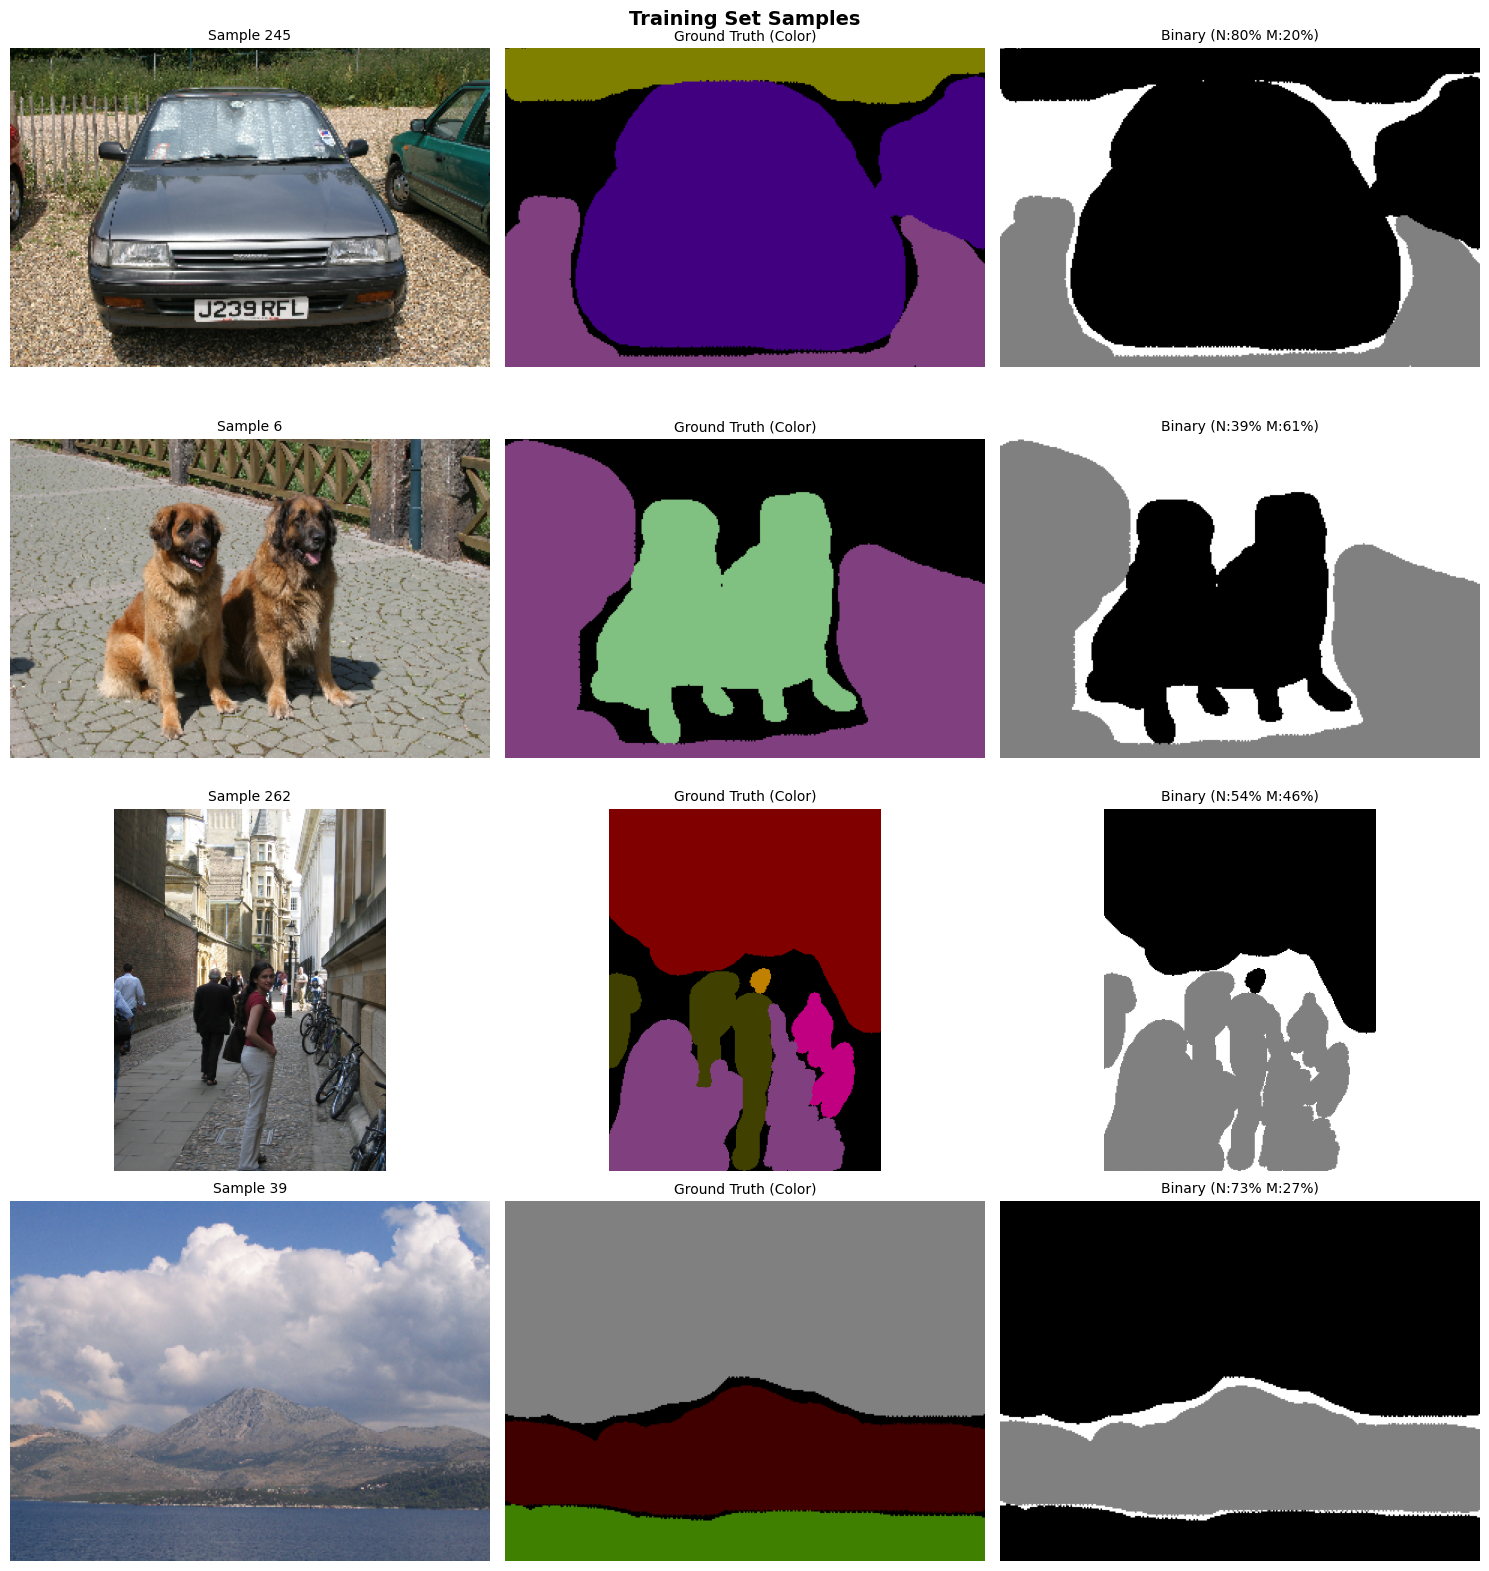

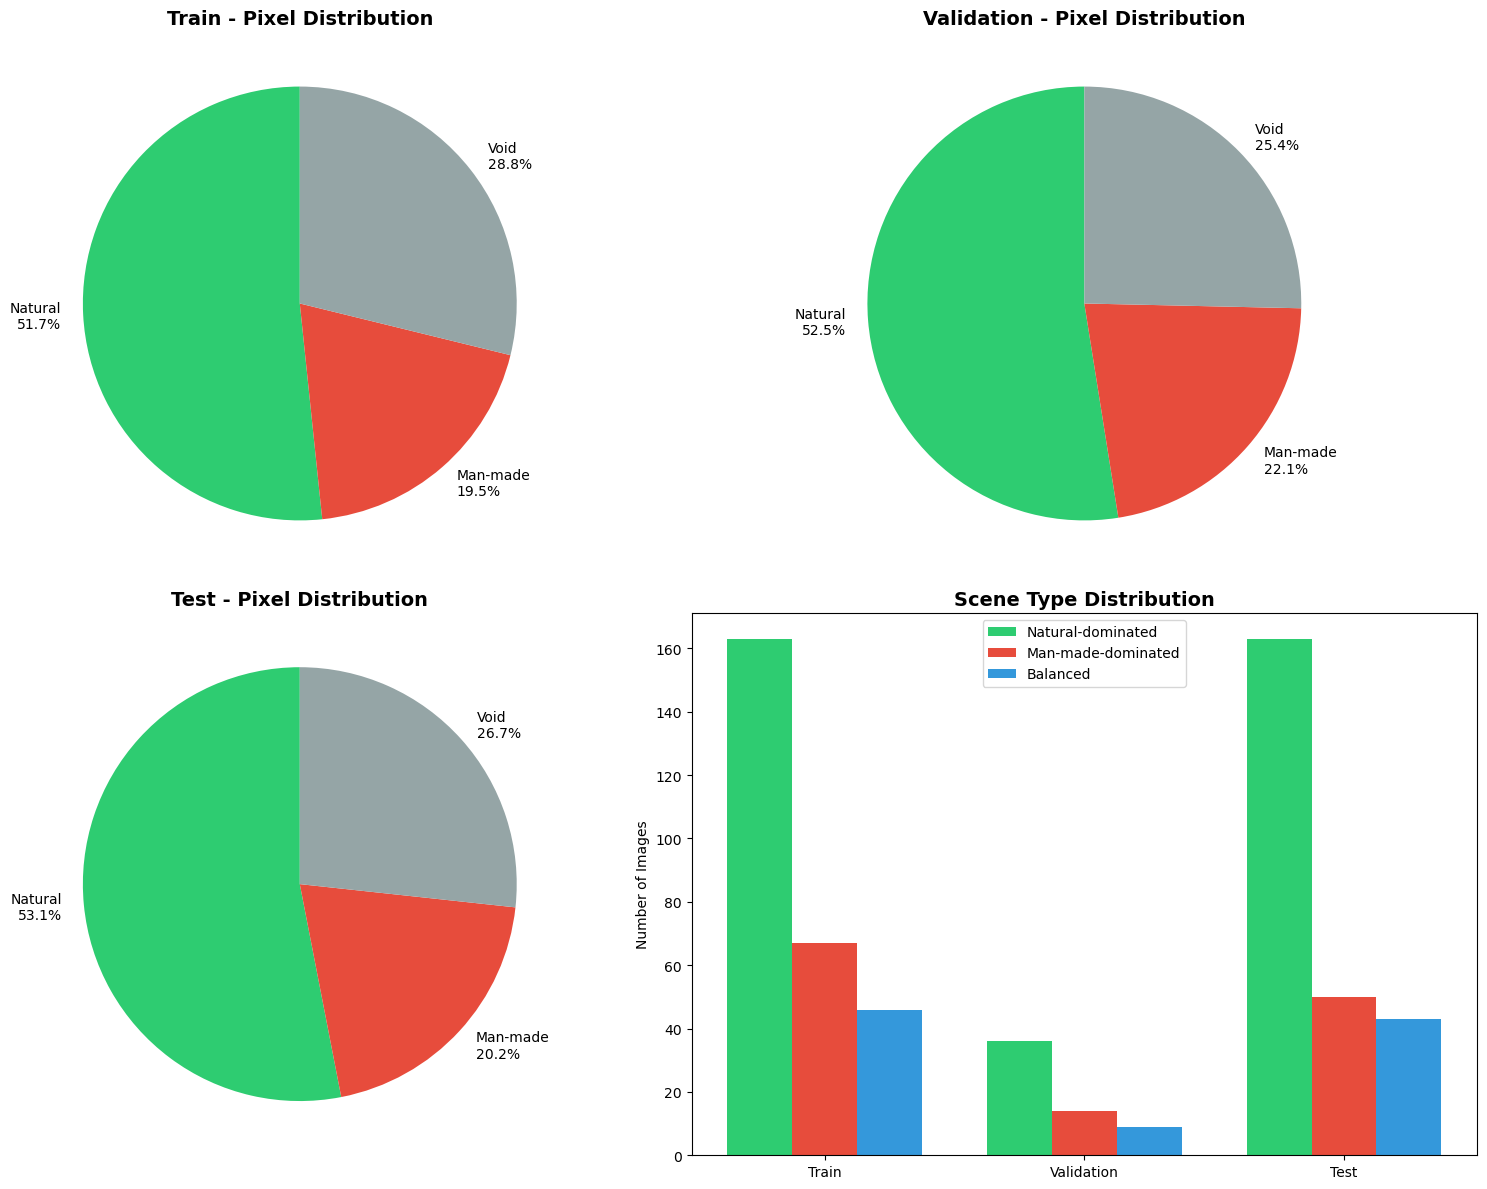

In [8]:
def visualize_samples(img_paths, gt_paths, dataset_name="Dataset", num_samples=6):
    """Visualize random samples from dataset"""
    if len(img_paths) == 0:
        print("Dataset is empty")
        return
    
    np.random.seed(RANDOM_SEED)
    indices = np.random.choice(len(img_paths), min(num_samples, len(img_paths)), replace=False)
    
    mapping = get_msrc_mapping()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample_idx in enumerate(indices):
        img = cv2.imread(img_paths[sample_idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        gt_img = cv2.imread(gt_paths[sample_idx])
        gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
        gt_mask = mask_to_binary(gt_img, mapping)
        
        nat = np.sum(gt_mask == 0)
        man = np.sum(gt_mask == 1)
        void = np.sum(gt_mask == 255)
        valid = nat + man
        
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f"Sample {sample_idx}", fontsize=10)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(gt_img)
        axes[idx, 1].set_title("Ground Truth (Color)", fontsize=10)
        axes[idx, 1].axis('off')
        
        vis_mask = gt_mask.copy()
        vis_mask[vis_mask == 255] = 2
        axes[idx, 2].imshow(vis_mask, cmap='gray', vmin=0, vmax=2)
        if valid > 0:
            nat_pct = nat/valid*100
            man_pct = man/valid*100
            axes[idx, 2].set_title(f"Binary (N:{nat_pct:.0f}% M:{man_pct:.0f}%)", fontsize=10)
        axes[idx, 2].axis('off')
    
    plt.suptitle(f"{dataset_name} Samples", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_dataset_distribution(train_stats, val_stats, test_stats):
    """Plot dataset class distribution"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    datasets = ['Train', 'Validation', 'Test']
    stats_list = [train_stats, val_stats, test_stats]
    
    for idx, (dataset, stats) in enumerate(zip(datasets, stats_list)):
        ax = axes[0, idx] if idx < 2 else axes[1, 0]
        
        nat = stats.get('natural_pixels', 0)
        man = stats.get('manmade_pixels', 0)
        void = stats.get('void_pixels', 0)
        total = nat + man + void
        
        if total > 0:
            sizes = [nat, man, void]
            nat_pct = nat/total*100
            man_pct = man/total*100
            void_pct = void/total*100
            labels = [f'Natural\n{nat_pct:.1f}%', 
                     f'Man-made\n{man_pct:.1f}%', 
                     f'Void\n{void_pct:.1f}%']
            colors = ['#2ecc71', '#e74c3c', '#95a5a6']
            ax.pie(sizes, labels=labels, colors=colors, startangle=90)
            ax.set_title(f'{dataset} - Pixel Distribution', fontsize=14, fontweight='bold')
    
    ax = axes[1, 1]
    x = np.arange(len(datasets))
    width = 0.25
    
    nat_dominant = [s.get('natural_dominant', 0) for s in stats_list]
    man_dominant = [s.get('manmade_dominant', 0) for s in stats_list]
    balanced = [s.get('balanced', 0) for s in stats_list]
    
    ax.bar(x - width, nat_dominant, width, label='Natural-dominated', color='#2ecc71')
    ax.bar(x, man_dominant, width, label='Man-made-dominated', color='#e74c3c')
    ax.bar(x + width, balanced, width, label='Balanced', color='#3498db')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_ylabel('Number of Images')
    ax.set_title('Scene Type Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    
    plt.tight_layout()
    plt.show()


# Visualize samples
visualize_samples(train_img_paths, train_gt_paths, "Training Set", num_samples=4)

# Plot distribution
if train_stats and val_stats and test_stats:
    plot_dataset_distribution(train_stats, val_stats, test_stats)

# Chapter 2: Feature Engineering and Model Architecture

This chapter contains:
- 2.1 Superpixel Generation with SLIC
- 2.2 Feature Extraction Pipeline
  - Base features (color, texture)
  - **Context features (NEW)**
  - Spatial features
- 2.3 MRF Energy Function
  - Unary term (GMM-based)
  - Pairwise term with **adaptive parameters (NEW)**
  - **Scene-adaptive parameter selection (NEW)**
- 2.4 **Class Imbalance Handling (NEW)**
  - Weighted loss implementation
  - Cost-sensitive threshold tuning

## 2.1 Superpixel Generation with SLIC

Superpixel test:
  Image shape: (213, 320, 3)
  Number of superpixels: 316


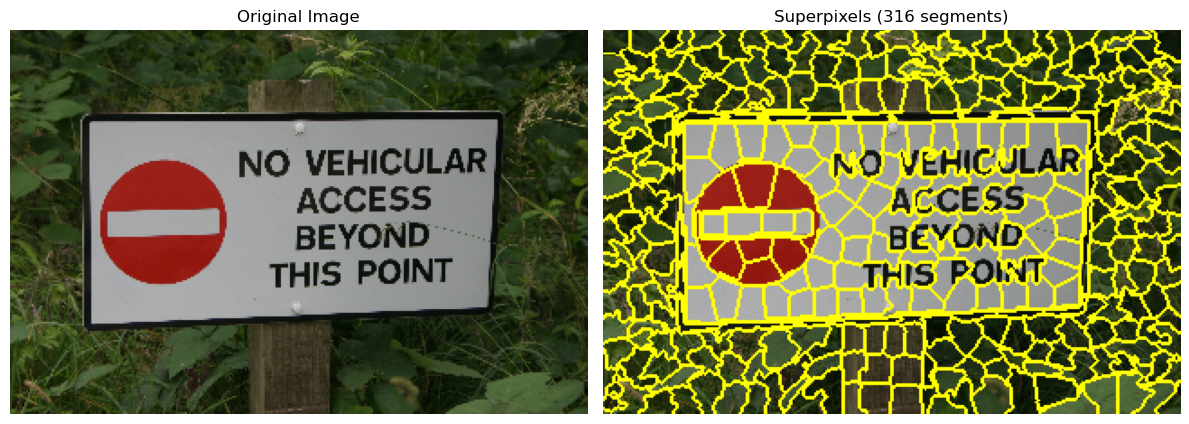

In [9]:
def generate_superpixels_adaptive(image_source, target_density=SUPERPIXEL_TARGET_DENSITY):
    """
    Adaptive superpixel segmentation - dynamically adjust number based on image size
    
    Parameters:
        image_source: Image path (string) or loaded RGB image (numpy array)
        target_density: Target density (superpixels/pixels)
    
    Returns:
        image: RGB image
        segments: Superpixel label matrix
    """
    if isinstance(image_source, str):
        image = cv2.imread(image_source)
        if image is None:
            raise FileNotFoundError(f"Cannot read image: {image_source}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif isinstance(image_source, np.ndarray):
        image = image_source
    else:
        raise ValueError("image_source must be file path or RGB numpy array")

    h, w = image.shape[:2]
    n_pixels = h * w
    n_segments = int(n_pixels * target_density)
    n_segments = max(SUPERPIXEL_MIN_SEGMENTS, min(n_segments, SUPERPIXEL_MAX_SEGMENTS))

    segments = slic(image, n_segments=n_segments, compactness=SUPERPIXEL_COMPACTNESS, 
                    sigma=SUPERPIXEL_SIGMA, start_label=0)
    return image, segments


# Test superpixel generation
if len(train_img_paths) > 0:
    test_img, test_segments = generate_superpixels_adaptive(train_img_paths[0])
    print(f"Superpixel test:")
    print(f"  Image shape: {test_img.shape}")
    print(f"  Number of superpixels: {len(np.unique(test_segments))}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(test_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    boundaries = mark_boundaries(test_img, test_segments, color=(1, 1, 0))
    axes[1].imshow(boundaries)
    axes[1].set_title(f"Superpixels ({len(np.unique(test_segments))} segments)")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

## 2.2 Feature Extraction Pipeline

### 2.2.1 Base Features (16-dimensional)
- LAB color mean (3)
- LAB color std (3)
- HSV mean (3)
- Gradient features (3)
- Shape/Position features (4)

In [10]:
def extract_base_features(image, segments, sp_id):
    """
    Extract base features for a single superpixel
    
    Returns: 16-dimensional feature vector
    """
    mask = (segments == sp_id)
    if mask.sum() == 0:
        return None
    
    # Color spaces
    image_lab = skcolor.rgb2lab(image)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Gradient
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = cv2.magnitude(grad_x, grad_y)
    grad_mag_norm = grad_mag / (np.max(grad_mag) + 1e-6)
    
    # Edge
    edges = cv2.Canny(gray, 60, 150)
    
    # Extract pixels
    lab_pixels = image_lab[mask]
    hsv_pixels = image_hsv[mask]
    grad_pixels = grad_mag_norm[mask]
    edge_pixels = edges[mask]
    
    # Color features (LAB)
    lab_mean = np.mean(lab_pixels, axis=0)  # 3
    lab_std = np.std(lab_pixels, axis=0)    # 3
    
    # HSV features
    hsv_mean = np.mean(hsv_pixels, axis=0)  # 3
    
    # Texture/Edge features
    grad_mean = np.mean(grad_pixels)        # 1
    grad_std = np.std(grad_pixels)          # 1
    edge_density = np.mean(edge_pixels > 0) # 1
    
    # Position & Shape features
    total_pixels = image.shape[0] * image.shape[1]
    area_ratio = mask.sum() / total_pixels   # 1
    y_coords, x_coords = np.where(mask)
    y_center = np.mean(y_coords) / image.shape[0]  # 1
    x_center = np.mean(x_coords) / image.shape[1]  # 1
    
    # Global contrast
    global_lab_mean = np.mean(image_lab.reshape(-1, 3), axis=0)
    color_contrast = np.linalg.norm(lab_mean - global_lab_mean)  # 1
    
    return np.concatenate([
        lab_mean,                                          # 3
        lab_std,                                           # 3
        hsv_mean,                                          # 3
        [grad_mean, grad_std, edge_density],              # 3
        [area_ratio, y_center, x_center, color_contrast]  # 4
    ])  # Total: 16


print("Base feature extraction function defined (16 dimensions)")

Base feature extraction function defined (16 dimensions)


### 2.2.2 Context Features (NEW)

Enhanced features from neighboring superpixels:
- Mean/Std/Max/Min of neighbor features
- Local histogram features
- Edge histogram in neighborhood

In [11]:
def find_adjacent_superpixels(segments, sp_id):
    """
    Find all adjacent superpixels for a given superpixel ID
    
    Returns: list of adjacent superpixel IDs
    """
    mask = (segments == sp_id)
    
    # Dilate the mask to find neighbors
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
    
    # Find neighbor pixels (dilated but not original)
    neighbor_region = dilated.astype(bool) & ~mask
    
    # Get unique superpixel IDs in neighbor region
    neighbor_ids = np.unique(segments[neighbor_region])
    
    return [n for n in neighbor_ids if n != sp_id]


def extract_context_features(image, segments, sp_id, base_features_dict):
    """
    Extract context features from neighboring superpixels (NEW)
    
    Parameters:
        image: RGB image
        segments: Superpixel labels
        sp_id: Current superpixel ID
        base_features_dict: Dictionary of precomputed base features for all superpixels
    
    Returns: context feature vector (32 dimensions)
    """
    neighbors = find_adjacent_superpixels(segments, sp_id)
    
    if len(neighbors) == 0:
        # No neighbors - return zeros
        return np.zeros(FEATURE_DIM_CONTEXT)
    
    # Collect neighbor features
    neighbor_features = []
    for n_id in neighbors:
        if n_id in base_features_dict:
            neighbor_features.append(base_features_dict[n_id])
    
    if len(neighbor_features) == 0:
        return np.zeros(FEATURE_DIM_CONTEXT)
    
    neighbor_features = np.array(neighbor_features)
    
    # Aggregate statistics
    mean_feats = np.mean(neighbor_features, axis=0)  # 16
    std_feats = np.std(neighbor_features, axis=0)    # 16
    
    # Could also add max/min, but keeping to 32 dims for now
    context_vector = np.concatenate([mean_feats, std_feats])
    
    return context_vector


def extract_local_histogram_features(image, segments, sp_id, n_bins=8):
    """
    Extract local histogram features in superpixel neighborhood
    
    Returns: histogram feature vector
    """
    mask = (segments == sp_id)
    neighbors = find_adjacent_superpixels(segments, sp_id)
    
    # Combined mask of sp and neighbors
    combined_mask = mask.copy()
    for n_id in neighbors:
        combined_mask |= (segments == n_id)
    
    # Extract pixels in neighborhood
    region_pixels = image[combined_mask]
    
    if len(region_pixels) == 0:
        return np.zeros(n_bins * 3)  # RGB histograms
    
    # Color histograms
    hist_features = []
    for c in range(3):  # R, G, B
        hist, _ = np.histogram(region_pixels[:, c], bins=n_bins, range=(0, 255))
        hist = hist / (np.sum(hist) + 1e-6)  # Normalize
        hist_features.extend(hist)
    
    return np.array(hist_features)


print("Context feature extraction functions defined")
print("  - find_adjacent_superpixels()")
print("  - extract_context_features() -> 32 dims")
print("  - extract_local_histogram_features() -> 24 dims")

Context feature extraction functions defined
  - find_adjacent_superpixels()
  - extract_context_features() -> 32 dims
  - extract_local_histogram_features() -> 24 dims


### 2.2.3 Spatial Context Features (NEW)

Additional spatial encoding:
- Distance to image center
- Relative position encoding
- Boundary strength features

In [12]:
def extract_spatial_features(image, segments, sp_id):
    """
    Extract spatial context features (NEW)
    
    Returns: 6-dimensional spatial feature vector
    """
    mask = (segments == sp_id)
    h, w = image.shape[:2]
    
    # Centroid
    y_coords, x_coords = np.where(mask)
    if len(y_coords) == 0:
        return np.zeros(6)
    
    y_center = np.mean(y_coords)
    x_center = np.mean(x_coords)
    
    # Distance to image center (normalized)
    img_center_y, img_center_x = h / 2, w / 2
    dist_to_center = np.sqrt((y_center - img_center_y)**2 + (x_center - img_center_x)**2)
    max_dist = np.sqrt(img_center_y**2 + img_center_x**2)
    normalized_dist = dist_to_center / max_dist  # 1
    
    # Relative position (normalized 0-1)
    rel_y = y_center / h  # 1
    rel_x = x_center / w  # 1
    
    # Boundary strength (perimeter / area)
    perimeter = np.sum(cv2.Canny(mask.astype(np.uint8) * 255, 100, 200) > 0)
    area = mask.sum()
    boundary_strength = perimeter / (area + 1e-6)  # 1
    
    # Compactness (4 * pi * area / perimeter^2)
    compactness = 4 * np.pi * area / (perimeter**2 + 1e-6)  # 1
    
    # Aspect ratio of bounding box
    if len(y_coords) > 1 and len(x_coords) > 1:
        bbox_h = np.max(y_coords) - np.min(y_coords) + 1
        bbox_w = np.max(x_coords) - np.min(x_coords) + 1
        aspect_ratio = min(bbox_h, bbox_w) / (max(bbox_h, bbox_w) + 1e-6)  # 1
    else:
        aspect_ratio = 1.0
    
    return np.array([
        normalized_dist,
        rel_y,
        rel_x,
        boundary_strength,
        compactness,
        aspect_ratio
    ])


print("Spatial feature extraction defined (6 dimensions)")

Spatial feature extraction defined (6 dimensions)


### 2.2.4 Complete Feature Extraction Pipeline

Combines:
- Base features (16 dims)
- Context features (32 dims) - **NEW**
- Spatial features (6 dims) - **NEW**

Total: 54 dimensions (enhanced from original 16)

In [13]:
def extract_features_and_labels(image, segments, gt_mask=None, use_context=True, use_spatial=True):
    """
    Extract all features from superpixels (enhanced version)
    
    Parameters:
        image: RGB image
        segments: Superpixel labels
        gt_mask: Ground truth mask (optional)
        use_context: Whether to include context features (NEW)
        use_spatial: Whether to include spatial features (NEW)
    
    Returns:
        features: Feature matrix [N x D]
        labels: Label array [N]
    """
    # Precompute color spaces
    image_lab = skcolor.rgb2lab(image)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = cv2.magnitude(grad_x, grad_y)
    grad_mag_norm = grad_mag / (np.max(grad_mag) + 1e-6)
    edges = cv2.Canny(gray, 60, 150)

    total_pixels = image.shape[0] * image.shape[1]
    global_lab_mean = np.mean(image_lab.reshape(-1, 3), axis=0)
    superpixel_ids = np.unique(segments)

    # First pass: compute base features for all superpixels
    base_features_dict = {}
    
    for sp_id in superpixel_ids:
        mask = (segments == sp_id)
        if mask.sum() == 0:
            continue

        lab_pixels = image_lab[mask]
        hsv_pixels = image_hsv[mask]
        grad_pixels = grad_mag_norm[mask]
        edge_pixels = edges[mask]

        lab_mean = np.mean(lab_pixels, axis=0)
        lab_std = np.std(lab_pixels, axis=0)
        hsv_mean = np.mean(hsv_pixels, axis=0)
        grad_mean = np.mean(grad_pixels)
        grad_std = np.std(grad_pixels)
        edge_density = np.mean(edge_pixels > 0)
        area_ratio = mask.sum() / total_pixels
        y_coords, x_coords = np.where(mask)
        y_center = np.mean(y_coords) / image.shape[0]
        x_center = np.mean(x_coords) / image.shape[1]
        color_contrast = np.linalg.norm(lab_mean - global_lab_mean)

        base_feat = np.concatenate([
            lab_mean, lab_std, hsv_mean,
            [grad_mean, grad_std, edge_density, area_ratio, y_center, x_center, color_contrast]
        ])
        base_features_dict[sp_id] = base_feat

    # Second pass: combine all features
    features = []
    labels = []

    for sp_id in superpixel_ids:
        if sp_id not in base_features_dict:
            continue
        
        mask = (segments == sp_id)
        
        # Base features (16)
        feat_vector = base_features_dict[sp_id].copy()
        
        # Context features (32) - NEW
        if use_context:
            context_feat = extract_context_features(image, segments, sp_id, base_features_dict)
            feat_vector = np.concatenate([feat_vector, context_feat])
        
        # Spatial features (6) - NEW
        if use_spatial:
            spatial_feat = extract_spatial_features(image, segments, sp_id)
            feat_vector = np.concatenate([feat_vector, spatial_feat])
        
        features.append(feat_vector)

        # Labels
        if gt_mask is not None:
            gt_pixels = gt_mask[mask]
            counts = np.bincount(gt_pixels.astype(int), minlength=256)
            count_0 = counts[0]
            count_1 = counts[1]
            count_void = counts[255]

            if count_void > (count_0 + count_1):
                label = 255
            else:
                label = 0 if count_0 > count_1 else 1
            labels.append(label)

    return np.array(features), np.array(labels)


# Test enhanced feature extraction
if len(train_img_paths) > 0:
    test_img, test_segments = generate_superpixels_adaptive(train_img_paths[0])
    gt_img = cv2.imread(train_gt_paths[0])
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    gt_mask = mask_to_binary(gt_img, get_msrc_mapping())
    
    # Extract with all features
    feats_full, labs = extract_features_and_labels(test_img, test_segments, gt_mask, 
                                                    use_context=True, use_spatial=True)
    
    # Extract base only (for comparison)
    feats_base, _ = extract_features_and_labels(test_img, test_segments, gt_mask, 
                                                 use_context=False, use_spatial=False)
    
    print(f"Feature extraction test:")
    print(f"  Number of superpixels: {len(feats_full)}")
    print(f"  Base feature dimension: {feats_base.shape[1]}")
    print(f"  Full feature dimension: {feats_full.shape[1]}")
    print(f"  Enhancement: +{feats_full.shape[1] - feats_base.shape[1]} dimensions")

Feature extraction test:
  Number of superpixels: 316
  Base feature dimension: 16
  Full feature dimension: 54
  Enhancement: +38 dimensions


## 2.3 MRF Energy Function

### 2.3.1 Adaptive Lambda Parameter (NEW)

Implements adaptive λ that adjusts based on:
- Edge density
- Color variance
- Scene complexity

In [14]:
def compute_adaptive_lambda(image, superpixels, base_lambda=MRF_BASE_LAMBDA):
    """
    Compute adaptive lambda based on image characteristics (NEW)
    
    Lambda adjusts based on:
    - Edge density: Higher for images with many edges
    - Color variance: Higher for colorful/complex images
    - Scene complexity: Combination of above
    
    Parameters:
        image: RGB image
        superpixels: Superpixel segmentation
        base_lambda: Base lambda value
    
    Returns:
        adaptive_lambda: Adjusted lambda value
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate edge strength
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.mean(edges > 0)
    
    # Calculate color variance (in LAB space for perceptual accuracy)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    color_variance = np.std(lab)
    
    # Calculate local variance (texture complexity)
    local_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    texture_complexity = min(local_var / 1000, 1.0)  # Normalize
    
    # Adaptive adjustment
    # Higher edge density -> need stronger smoothing -> higher lambda
    # Higher color variance -> more diverse regions -> lower lambda to preserve details
    edge_factor = 1 + edge_density * 2  # Range: 1 to 3
    color_factor = 1 - (color_variance / 200) * 0.5  # Range: 0.5 to 1
    color_factor = max(0.5, min(1.0, color_factor))
    
    adaptive_lambda = base_lambda * edge_factor * color_factor * (1 + texture_complexity * 0.5)
    
    # Clamp to reasonable range
    adaptive_lambda = max(MRF_LAMBDA_RANGE[0], min(MRF_LAMBDA_RANGE[1], adaptive_lambda))
    
    return adaptive_lambda


def compute_adaptive_sigma(image, superpixels, base_sigma=MRF_BASE_SIGMA):
    """
    Compute adaptive sigma for color similarity (NEW)
    
    Sigma adjusts based on color distribution in the image
    
    Parameters:
        image: RGB image
        superpixels: Superpixel segmentation
        base_sigma: Base sigma value
    
    Returns:
        adaptive_sigma: Adjusted sigma value
    """
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Compute mean color per superpixel
    sp_colors = []
    for sp_id in np.unique(superpixels):
        mask = (superpixels == sp_id)
        sp_colors.append(np.mean(lab[mask], axis=0))
    sp_colors = np.array(sp_colors)
    
    # Compute pairwise color distances
    color_dists = []
    for i in range(len(sp_colors)):
        for j in range(i+1, min(i+10, len(sp_colors))):  # Sample neighbors
            dist = np.linalg.norm(sp_colors[i] - sp_colors[j])
            color_dists.append(dist)
    
    if len(color_dists) == 0:
        return base_sigma
    
    # Use median distance to set sigma
    median_dist = np.median(color_dists)
    
    # Adaptive sigma: larger if colors are more spread out
    adaptive_sigma = base_sigma * (median_dist / 30)  # 30 is typical LAB distance
    
    # Clamp to reasonable range
    adaptive_sigma = max(MRF_SIGMA_RANGE[0], min(MRF_SIGMA_RANGE[1], adaptive_sigma))
    
    return adaptive_sigma


print("Adaptive MRF parameters defined:")
print("  - compute_adaptive_lambda()")
print("  - compute_adaptive_sigma()")

Adaptive MRF parameters defined:
  - compute_adaptive_lambda()
  - compute_adaptive_sigma()


### 2.3.2 Scene-Adaptive Parameter Selection (NEW)

Different parameter sets for:
- Natural-dominated scenes (>70% natural pixels)
- Man-made-dominated scenes (>70% man-made pixels)
- Balanced scenes (30%-70%)

In [15]:
def detect_scene_type(image, segments, classifier):
    """
    Detect scene type based on initial classification (NEW)
    
    Returns: 'natural', 'manmade', or 'balanced'
    """
    feats, _ = extract_features_and_labels(image, segments, None, use_context=False, use_spatial=False)
    
    if len(feats) == 0:
        return 'balanced'
    
    # Get initial predictions
    predictions = classifier.predict(feats)
    
    natural_count = np.sum(predictions == 0)
    manmade_count = np.sum(predictions == 1)
    total = natural_count + manmade_count
    
    if total == 0:
        return 'balanced'
    
    natural_ratio = natural_count / total
    
    if natural_ratio > SCENE_NATURAL_THRESHOLD:
        return 'natural'
    elif natural_ratio < (1 - SCENE_MANMADE_THRESHOLD):
        return 'manmade'
    else:
        return 'balanced'


def get_scene_parameters(scene_type):
    """
    Get optimized MRF parameters for scene type (NEW)
    
    Returns: (lambda_smooth, sigma)
    """
    params = {
        'natural': {
            'lambda': 25,  # Natural scenes: moderate smoothing
            'sigma': 30    # Allow more color variation
        },
        'manmade': {
            'lambda': 15,  # Man-made: less smoothing (preserve edges)
            'sigma': 20    # Stricter color similarity
        },
        'balanced': {
            'lambda': 20,  # Balanced: middle ground
            'sigma': 25
        }
    }
    
    return params.get(scene_type, params['balanced'])


print("Scene-adaptive parameter selection defined:")
print("  - detect_scene_type()")
print("  - get_scene_parameters()")
print()
print("Scene parameter presets:")
for scene, params in [('natural', {'lambda': 25, 'sigma': 30}), 
                       ('manmade', {'lambda': 15, 'sigma': 20}),
                       ('balanced', {'lambda': 20, 'sigma': 25})]:
    print(f"  {scene}: lambda={params['lambda']}, sigma={params['sigma']}")

Scene-adaptive parameter selection defined:
  - detect_scene_type()
  - get_scene_parameters()

Scene parameter presets:
  natural: lambda=25, sigma=30
  manmade: lambda=15, sigma=20
  balanced: lambda=20, sigma=25


### 2.3.3 MRF Inference with Adaptive Parameters

Complete MRF inference using Graph Cut with:
- Unary potentials from classifier
- Pairwise potentials with adaptive λ and σ

In [16]:
def perform_mrf_inference(image, segments, classifier, lambda_smooth=20, sigma=20, 
                          use_adaptive=True, use_scene_params=True):
    """
    Perform MRF inference using Graph Cut (Enhanced)
    
    Parameters:
        image: RGB image
        segments: Superpixel labels
        classifier: Classifier with predict_proba method
        lambda_smooth: Smoothness weight
        sigma: Color similarity sensitivity
        use_adaptive: Use adaptive lambda/sigma (NEW)
        use_scene_params: Use scene-based parameters (NEW)
    
    Returns:
        result_labels: Predicted labels for each superpixel
    """
    # 1. Extract features and unary potentials
    feats, _ = extract_features_and_labels(image, segments, gt_mask=None, 
                                            use_context=False, use_spatial=False)
    probs = classifier.predict_proba(feats)
    
    # Convert to energy (negative log likelihood)
    epsilon = 1e-10
    E_data_0 = -np.log(probs[:, 0] + epsilon).flatten()
    E_data_1 = -np.log(probs[:, 1] + epsilon).flatten()
    
    n_superpixels = len(feats)
    
    # 2. Determine parameters
    if use_scene_params:
        scene_type = detect_scene_type(image, segments, classifier)
        scene_params = get_scene_parameters(scene_type)
        lambda_smooth = scene_params['lambda']
        sigma = scene_params['sigma']
    
    if use_adaptive:
        lambda_smooth = compute_adaptive_lambda(image, segments, lambda_smooth)
        sigma = compute_adaptive_sigma(image, segments, sigma)
    
    # 3. Build graph
    g = maxflow.Graph[float](n_superpixels, n_superpixels * 4)
    nodes_raw = g.add_nodes(n_superpixels)
    
    # Handle node mapping
    try:
        _ = len(nodes_raw)
        node_mapping = nodes_raw
    except TypeError:
        start_node = int(nodes_raw)
        node_mapping = range(start_node, start_node + n_superpixels)
    
    # 4. Add T-links (source and sink)
    for i in range(n_superpixels):
        node_id = node_mapping[i]
        w_source = float(E_data_1[i])  # Cost of assigning to Man-made
        w_sink = float(E_data_0[i])    # Cost of assigning to Natural
        g.add_tedge(node_id, w_source, w_sink)
    
    # 5. Add N-links (neighbor smoothness)
    rag = graph.rag_mean_color(image, segments)
    
    for u, v, data in rag.edges(data=True):
        if u >= n_superpixels or v >= n_superpixels:
            continue
        
        node_u = node_mapping[u]
        node_v = node_mapping[v]
        
        # Color difference
        color_u = feats[u, :3]  # LAB mean
        color_v = feats[v, :3]
        dist_sq = np.sum((color_u - color_v)**2)
        
        # Gaussian kernel weight
        weight = float(lambda_smooth * np.exp(-dist_sq / (2 * sigma**2)))
        
        # Add bidirectional edge
        g.add_edge(node_u, node_v, weight, weight)
    
    # 6. Run max-flow
    flow = g.maxflow()
    
    # 7. Get segmentation result
    result_labels = []
    for i in range(n_superpixels):
        node_id = node_mapping[i]
        segment = g.get_segment(node_id)  # 0=Source(Natural), 1=Sink(Man-made)
        result_labels.append(segment)
    
    return np.array(result_labels)


def labels_to_mask(segments, labels):
    """Map superpixel labels back to full image mask"""
    mask = np.zeros(segments.shape, dtype=np.uint8)
    for i, sp_id in enumerate(np.unique(segments)):
        mask[segments == sp_id] = labels[i]
    return mask


print("MRF inference function defined with adaptive parameters")

MRF inference function defined with adaptive parameters


### 2.3.4 Parameter Grid Search (NEW)

Implement grid search for optimal hyperparameter selection

In [17]:
def grid_search_mrf_params(val_img_paths, val_gt_paths, classifier, 
                           lambda_range=(5, 50, 5), sigma_range=(10, 50, 5),
                           max_samples=10):
    """
    Grid search for optimal MRF parameters (NEW)
    """
    lambdas = np.arange(lambda_range[0], lambda_range[1] + 1, lambda_range[2])
    sigmas = np.arange(sigma_range[0], sigma_range[1] + 1, sigma_range[2])
    
    n_combos = len(lambdas) * len(sigmas)
    print(f"Grid Search: {len(lambdas)} lambdas x {len(sigmas)} sigmas = {n_combos} combinations")
    print(f"Using {min(max_samples, len(val_img_paths))} validation samples")
    
    results = np.zeros((len(lambdas), len(sigmas)))
    best_acc = 0
    best_params = {'lambda': lambdas[0], 'sigma': sigmas[0]}
    
    sample_paths = val_img_paths[:max_samples]
    sample_gts = val_gt_paths[:max_samples]
    
    mapping = get_msrc_mapping()
    
    for i, lam in enumerate(lambdas):
        for j, sig in enumerate(sigmas):
            total_correct = 0
            total_valid = 0
            
            for img_p, gt_p in zip(sample_paths, sample_gts):
                img = cv2.imread(img_p)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                gt_img = cv2.imread(gt_p)
                gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
                gt_mask = mask_to_binary(gt_img, mapping)
                
                _, segments = generate_superpixels_adaptive(img)
                
                predictions = perform_mrf_inference(img, segments, classifier, 
                                                   lambda_smooth=lam, sigma=sig,
                                                   use_adaptive=False, use_scene_params=False)
                pred_mask = labels_to_mask(segments, predictions)
                
                valid = (gt_mask != 255)
                total_correct += np.sum(pred_mask[valid] == gt_mask[valid])
                total_valid += np.sum(valid)
            
            acc = total_correct / total_valid if total_valid > 0 else 0
            results[i, j] = acc
            
            if acc > best_acc:
                best_acc = acc
                best_params = {'lambda': lam, 'sigma': sig}
            
            print(f"  lambda={lam:2d}, sigma={sig:2d}: acc={acc*100:.2f}%")
    
    print(f"\nBest parameters: lambda={best_params['lambda']}, sigma={best_params['sigma']}")
    print(f"Best accuracy: {best_acc*100:.2f}%")
    
    # Visualize results
    plt.figure(figsize=(10, 8))
    plt.imshow(results * 100, cmap='viridis', aspect='auto')
    plt.colorbar(label='Accuracy (%)')
    plt.xlabel('Sigma')
    plt.ylabel('Lambda')
    plt.xticks(range(len(sigmas)), sigmas)
    plt.yticks(range(len(lambdas)), lambdas)
    plt.title('MRF Parameter Grid Search Results')
    
    best_i = np.where(lambdas == best_params['lambda'])[0][0]
    best_j = np.where(sigmas == best_params['sigma'])[0][0]
    plt.scatter([best_j], [best_i], marker='*', s=300, c='red', label='Best')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return best_params, results


print("Grid search function defined")

Grid search function defined


## 2.4 Class Imbalance Handling (NEW)

Implements:
- Weighted loss with inverse frequency weights
- Cost-sensitive learning
- Focal loss approach
- SMOTE-like resampling at feature level

In [18]:
def compute_class_weights(labels):
    """
    Compute inverse frequency weights for class imbalance (NEW)
    
    Parameters:
        labels: Array of class labels (may contain 255 for void)
    
    Returns:
        weights: Dictionary with class weights
    """
    valid_mask = (labels != 255)
    valid_labels = labels[valid_mask]
    
    if len(valid_labels) == 0:
        return {0: 1.0, 1: 1.0}
    
    natural_count = np.sum(valid_labels == 0)
    manmade_count = np.sum(valid_labels == 1)
    
    total = natural_count + manmade_count
    
    if natural_count == 0 or manmade_count == 0:
        return {0: 1.0, 1: 1.0}
    
    # Inverse frequency weights
    weights = {
        0: total / (2 * natural_count),
        1: total / (2 * manmade_count)
    }
    
    return weights


def apply_sample_weights(features, labels, class_weights):
    """
    Create sample weights based on class weights
    
    Returns:
        sample_weights: Weight for each sample
    """
    sample_weights = np.ones(len(labels))
    
    for label, weight in class_weights.items():
        sample_weights[labels == label] = weight
    
    return sample_weights


print("Class weight computation functions defined")

Class weight computation functions defined


In [19]:
def focal_loss_weights(probs, labels, gamma=FOCAL_LOSS_GAMMA):
    """
    Compute focal loss weights (NEW)
    
    Focal loss: FL(p) = -(1-p)^gamma * log(p)
    This down-weights easy examples and focuses on hard ones
    
    Parameters:
        probs: Predicted probabilities [N, 2]
        labels: True labels [N]
        gamma: Focusing parameter (higher = more focus on hard examples)
    
    Returns:
        focal_weights: Weight for each sample
    """
    n_samples = len(labels)
    focal_weights = np.ones(n_samples)
    
    for i in range(n_samples):
        if labels[i] == 255:  # Skip void
            focal_weights[i] = 0
            continue
        
        # Get probability for true class
        p_true = probs[i, int(labels[i])]
        
        # Focal weight: (1 - p)^gamma
        focal_weights[i] = (1 - p_true) ** gamma
    
    return focal_weights


def cost_sensitive_threshold(probs, natural_cost=1.0, manmade_cost=1.5):
    """
    Apply cost-sensitive classification threshold (NEW)
    
    Adjusts decision threshold based on misclassification costs
    Higher cost for minority class -> lower threshold for that class
    
    Parameters:
        probs: Predicted probabilities [N, 2]
        natural_cost: Cost of misclassifying natural as man-made
        manmade_cost: Cost of misclassifying man-made as natural
    
    Returns:
        predictions: Adjusted predictions
    """
    # Adjust threshold: higher cost -> lower threshold
    total_cost = natural_cost + manmade_cost
    threshold = natural_cost / total_cost  # Default 0.5 if equal costs
    
    # If manmade_cost > natural_cost, threshold < 0.5
    # This means we predict man-made more often (protect minority class)
    predictions = (probs[:, 1] > threshold).astype(int)
    
    return predictions


print("Focal loss and cost-sensitive functions defined")

Focal loss and cost-sensitive functions defined


In [20]:
def smote_oversample(features, labels, target_ratio=1.0, k_neighbors=5):
    """
    SMOTE-like oversampling for minority class (NEW)
    
    Creates synthetic samples by interpolating between minority class samples
    
    Parameters:
        features: Feature matrix [N, D]
        labels: Label array [N]
        target_ratio: Target ratio of minority/majority class
        k_neighbors: Number of neighbors for interpolation
    
    Returns:
        aug_features: Augmented feature matrix
        aug_labels: Augmented label array
    """
    # Find minority class
    valid_mask = (labels != 255)
    valid_features = features[valid_mask]
    valid_labels = labels[valid_mask]
    
    natural_count = np.sum(valid_labels == 0)
    manmade_count = np.sum(valid_labels == 1)
    
    if natural_count == 0 or manmade_count == 0:
        return features, labels
    
    # Determine minority class
    if natural_count < manmade_count:
        minority_class = 0
        majority_count = manmade_count
        minority_count = natural_count
    else:
        minority_class = 1
        majority_count = natural_count
        minority_count = manmade_count
    
    # Calculate how many samples to generate
    target_count = int(majority_count * target_ratio)
    n_synthetic = target_count - minority_count
    
    if n_synthetic <= 0:
        return features, labels
    
    # Get minority class samples
    minority_features = valid_features[valid_labels == minority_class]
    
    # Generate synthetic samples
    synthetic_features = []
    
    for _ in range(n_synthetic):
        # Random sample from minority class
        idx = np.random.randint(len(minority_features))
        sample = minority_features[idx]
        
        # Find k nearest neighbors (simplified: random selection)
        neighbor_idx = np.random.randint(len(minority_features))
        neighbor = minority_features[neighbor_idx]
        
        # Interpolate
        alpha = np.random.random()
        synthetic = sample + alpha * (neighbor - sample)
        synthetic_features.append(synthetic)
    
    synthetic_features = np.array(synthetic_features)
    synthetic_labels = np.full(n_synthetic, minority_class)
    
    # Combine with original
    aug_features = np.vstack([features, synthetic_features])
    aug_labels = np.concatenate([labels, synthetic_labels])
    
    print(f"SMOTE: Generated {n_synthetic} synthetic samples for class {minority_class}")
    print(f"  Original: {len(features)} -> Augmented: {len(aug_features)}")
    
    return aug_features, aug_labels


print("SMOTE oversampling function defined")

SMOTE oversampling function defined


In [21]:
def build_dataset(img_paths, gt_paths, target_density=SUPERPIXEL_TARGET_DENSITY,
                  use_context=True, use_spatial=True):
    """Build feature dataset from images (Enhanced)"""
    all_features = []
    all_labels = []

    print(f"Building dataset from {len(img_paths)} images")
    print(f"  Context features: {use_context}")
    print(f"  Spatial features: {use_spatial}")
    
    start_time = time.time()

    for i, (img_p, gt_p) in enumerate(zip(img_paths, gt_paths)):
        img_bgr = cv2.imread(img_p)
        if img_bgr is None:
            continue
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        gt_img = cv2.imread(gt_p)
        if gt_img is None:
            continue
        gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
        mapping = get_msrc_mapping()
        gt_mask = mask_to_binary(gt_img, mapping)

        _, segments = generate_superpixels_adaptive(img, target_density)

        feats, labs = extract_features_and_labels(img, segments, gt_mask,
                                                   use_context=use_context,
                                                   use_spatial=use_spatial)

        all_features.append(feats)
        all_labels.append(labs)

        if (i + 1) % 50 == 0:
            print(f"   Processed {i + 1}/{len(img_paths)} images")

    X = np.vstack(all_features)
    y = np.concatenate(all_labels)
    
    # Remove void labels
    valid_mask = (y != 255)
    X = X[valid_mask]
    y = y[valid_mask]

    elapsed = time.time() - start_time
    print(f"\nDataset built in {elapsed:.1f}s")
    print(f"  Total samples: {len(X)}")
    print(f"  Feature dimension: {X.shape[1]}")
    print(f"  Natural: {np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%)")
    print(f"  Man-made: {np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")

    return X, y


# Build training dataset
print("Building training dataset...")
X_train, y_train = build_dataset(train_img_paths, train_gt_paths,
                                  use_context=True, use_spatial=True)

# Compute class weights
CLASS_WEIGHTS = compute_class_weights(y_train)
print(f"\nClass weights computed:")
print(f"  Natural (0): {CLASS_WEIGHTS[0]:.3f}")
print(f"  Man-made (1): {CLASS_WEIGHTS[1]:.3f}")

Building training dataset...
Building dataset from 276 images
  Context features: True
  Spatial features: True
   Processed 50/276 images
   Processed 100/276 images
   Processed 150/276 images
   Processed 200/276 images
   Processed 250/276 images

Dataset built in 137.2s
  Total samples: 71671
  Feature dimension: 54
  Natural: 53130 (74.1%)
  Man-made: 18541 (25.9%)

Class weights computed:
  Natural (0): 0.674
  Man-made (1): 1.933


### 2.4.2 Weighted GMM Classifier

GMM classifier with:
- Weighted training for class imbalance
- Cost-sensitive decision threshold
- Focal loss integration

In [22]:
class WeightedGMMClassifier:
    """
    GMM Classifier with class imbalance handling (Enhanced)
    
    Features:
    - Inverse frequency weighting
    - Cost-sensitive threshold
    - Focal loss compatible
    """
    
    def __init__(self, n_components=15, class_weights=None, 
                 natural_cost=1.0, manmade_cost=1.5):
        self.n_components = n_components
        self.class_weights = class_weights or {0: 1.0, 1: 1.0}
        self.natural_cost = natural_cost
        self.manmade_cost = manmade_cost
        self.scaler = StandardScaler()
        self.gmm_nat = None
        self.gmm_man = None
        
    def fit(self, X, y):
        """Fit GMM models for each class"""
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Separate classes
        X_natural = X_scaled[y == 0]
        X_manmade = X_scaled[y == 1]
        
        print(f"Training Weighted GMM:")
        print(f"  Natural samples: {len(X_natural)}")
        print(f"  Man-made samples: {len(X_manmade)}")
        print(f"  Class weights: Natural={self.class_weights[0]:.3f}, Man-made={self.class_weights[1]:.3f}")
        
        # Train GMMs
        self.gmm_nat = GaussianMixture(
            n_components=min(self.n_components, len(X_natural)),
            covariance_type='full',
            random_state=RANDOM_SEED
        )
        self.gmm_nat.fit(X_natural)
        
        self.gmm_man = GaussianMixture(
            n_components=min(self.n_components, len(X_manmade)),
            covariance_type='full',
            random_state=RANDOM_SEED
        )
        self.gmm_man.fit(X_manmade)
        
        print("  GMM training complete")
        
        return self
    
    def predict_proba(self, X):
        """Predict class probabilities with weighting"""
        X_scaled = self.scaler.transform(X)
        
        log_prob_nat = self.gmm_nat.score_samples(X_scaled)
        log_prob_man = self.gmm_man.score_samples(X_scaled)
        
        # Apply class weights (as log priors)
        log_prob_nat += np.log(self.class_weights[0])
        log_prob_man += np.log(self.class_weights[1])
        
        # Numerical stability
        max_log = np.maximum(log_prob_nat, log_prob_man)
        p_nat = np.exp(log_prob_nat - max_log)
        p_man = np.exp(log_prob_man - max_log)
        prob_sum = p_nat + p_man + 1e-10
        
        return np.column_stack([p_nat/prob_sum, p_man/prob_sum])
    
    def predict(self, X, use_cost_sensitive=True):
        """Predict with optional cost-sensitive threshold"""
        probs = self.predict_proba(X)
        
        if use_cost_sensitive:
            return cost_sensitive_threshold(probs, self.natural_cost, self.manmade_cost)
        else:
            return (probs[:, 1] > 0.5).astype(int)


print("WeightedGMMClassifier defined")

WeightedGMMClassifier defined


# Chapter 3: Training and Evaluation [KEEP UNCHANGED]

This chapter contains the original training and evaluation code.

## 3.1 Random Forest Classifier

In [23]:
# Train Random Forest
print("Training Random Forest...")
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    class_weight='balanced'  # Handle imbalance
)
rf_clf.fit(X_train, y_train)

train_preds = rf_clf.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)
print(f"Random Forest Training Accuracy: {train_acc*100:.2f}%")

Training Random Forest...
Random Forest Training Accuracy: 96.97%


## 3.2 SVM Classifier

In [ ]:
# Train SVM
print("Training SVM...")

# Feature normalization for SVM
scaler_svm = StandardScaler()
X_train_scaled_svm = scaler_svm.fit_transform(X_train)

svm_clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    class_weight='balanced',
    random_state=RANDOM_SEED
)
svm_clf.fit(X_train_scaled_svm, y_train)

# Wrapper for SVM
class SVMWrapper:
    def __init__(self, svm, scaler):
        self.svm = svm
        self.scaler = scaler
    
    def predict(self, X):
        return self.svm.predict(self.scaler.transform(X))
    
    def predict_proba(self, X):
        return self.svm.predict_proba(self.scaler.transform(X))

svm_clf_wrapper = SVMWrapper(svm_clf, scaler_svm)

train_preds = svm_clf_wrapper.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)
print(f"SVM Training Accuracy: {train_acc*100:.2f}%")

## 3.3 GMM Classifier (Weighted)

In [24]:
# Train Weighted GMM
print("Training Weighted GMM...")

gmm_clf = WeightedGMMClassifier(
    n_components=15,
    class_weights=CLASS_WEIGHTS,
    natural_cost=1.0,
    manmade_cost=CLASS_WEIGHTS[1]  # Higher cost for minority class
)
gmm_clf.fit(X_train, y_train)

train_preds = gmm_clf.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)
print(f"Weighted GMM Training Accuracy: {train_acc*100:.2f}%")

# Also train unweighted for comparison
print("\nTraining Unweighted GMM for comparison...")
gmm_clf_unweighted = WeightedGMMClassifier(
    n_components=15,
    class_weights={0: 1.0, 1: 1.0},
    natural_cost=1.0,
    manmade_cost=1.0
)
gmm_clf_unweighted.fit(X_train, y_train)

Training Weighted GMM...
Training Weighted GMM:
  Natural samples: 53130
  Man-made samples: 18541
  Class weights: Natural=0.674, Man-made=1.933
  GMM training complete
Weighted GMM Training Accuracy: 85.63%

Training Unweighted GMM for comparison...
Training Weighted GMM:
  Natural samples: 53130
  Man-made samples: 18541
  Class weights: Natural=1.000, Man-made=1.000
  GMM training complete


## 3.4 Evaluation Metrics

In [25]:
# Evaluation metric functions
def compute_confusion_matrix(y_true, y_pred, num_classes=2, ignore_label=255):
    """Compute confusion matrix, ignoring void regions"""
    valid_mask = (y_true != ignore_label)
    y_true_valid = y_true[valid_mask]
    y_pred_valid = y_pred[valid_mask]
    
    return confusion_matrix(y_true_valid, y_pred_valid, labels=list(range(num_classes)))


def compute_iou_per_class(conf_matrix):
    """Compute IoU for each class from confusion matrix"""
    tp = np.diag(conf_matrix)
    fn = conf_matrix.sum(axis=1) - tp
    fp = conf_matrix.sum(axis=0) - tp
    
    denominator = tp + fp + fn
    iou = np.where(denominator > 0, tp / denominator, 0.0)
    
    return iou


def compute_all_metrics(y_true, y_pred, num_classes=2, ignore_label=255):
    """Compute all evaluation metrics"""
    conf_matrix = compute_confusion_matrix(y_true, y_pred, num_classes, ignore_label)
    iou_per_class = compute_iou_per_class(conf_matrix)
    miou = np.mean(iou_per_class)
    
    valid_mask = (y_true != ignore_label)
    if np.sum(valid_mask) == 0:
        pa = 0.0
    else:
        correct = np.sum((y_true[valid_mask] == y_pred[valid_mask]))
        pa = correct / np.sum(valid_mask)
    
    tp = np.diag(conf_matrix)
    total_per_class = conf_matrix.sum(axis=1)
    pa_per_class = np.where(total_per_class > 0, tp / total_per_class, 0.0)
    mpa = np.mean(pa_per_class)
    
    return {
        'confusion_matrix': conf_matrix,
        'miou': miou,
        'iou_per_class': iou_per_class,
        'pixel_accuracy': pa,
        'mean_pixel_accuracy': mpa,
        'pa_per_class': pa_per_class
    }


def print_metrics(metrics, class_names=['Natural', 'Man-made']):
    """Print evaluation metrics"""
    print(f"\nPixel Accuracy (PA):           {metrics['pixel_accuracy']*100:.2f}%")
    print(f"Mean Pixel Accuracy (MPA):     {metrics['mean_pixel_accuracy']*100:.2f}%")
    print(f"Mean IoU (mIoU):               {metrics['miou']*100:.2f}%")
    
    print("\nPer-class metrics:")
    for i, name in enumerate(class_names):
        iou = metrics['iou_per_class'][i]
        acc = metrics['pa_per_class'][i]
        print(f"  {name}: IoU={iou*100:.2f}%, Acc={acc*100:.2f}%")


print("Evaluation metric functions defined")

Evaluation metric functions defined


## 3.5 Full Evaluation on Validation Set

In [26]:
def evaluate_with_full_metrics(img_paths, gt_paths, classifier, method_name="Method", 
                                use_mrf=False, max_samples=None, use_adaptive_mrf=True):
    """Evaluate classifier with full metrics"""
    if max_samples is not None:
        img_paths = img_paths[:max_samples]
        gt_paths = gt_paths[:max_samples]
    
    all_gt = []
    all_pred = []
    
    print(f"\nEvaluating {method_name} {'+ MRF' if use_mrf else ''}")
    print(f"Processing {len(img_paths)} images...")
    
    mapping = get_msrc_mapping()
    
    for i, (img_p, gt_p) in enumerate(zip(img_paths, gt_paths)):
        img = cv2.imread(img_p)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        gt_img = cv2.imread(gt_p)
        gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
        gt_mask = mask_to_binary(gt_img, mapping)
        
        _, segments = generate_superpixels_adaptive(img_p)
        features, _ = extract_features_and_labels(img, segments, None, 
                                                   use_context=False, use_spatial=False)
        
        if use_mrf:
            predictions = perform_mrf_inference(img, segments, classifier,
                                               use_adaptive=use_adaptive_mrf,
                                               use_scene_params=use_adaptive_mrf)
        else:
            predictions = classifier.predict(features)
        
        pred_mask = labels_to_mask(segments, predictions)
        
        all_gt.append(gt_mask.flatten())
        all_pred.append(pred_mask.flatten())
        
        if (i+1) % 20 == 0:
            print(f"  Progress: {i+1}/{len(img_paths)}")
    
    y_true = np.concatenate(all_gt)
    y_pred = np.concatenate(all_pred)
    
    metrics = compute_all_metrics(y_true, y_pred)
    print_metrics(metrics)
    
    return metrics


# Evaluate on validation set
EVAL_SAMPLES = min(len(val_img_paths), 30)

print("=" * 60)
print("EVALUATION ON VALIDATION SET")
print("=" * 60)

# GMM + MRF (Adaptive)
metrics_gmm_mrf = evaluate_with_full_metrics(
    val_img_paths, val_gt_paths, 
    gmm_clf, 
    method_name="Weighted GMM", 
    use_mrf=True, 
    max_samples=EVAL_SAMPLES,
    use_adaptive_mrf=True
)

# Random Forest + MRF
metrics_rf_mrf = evaluate_with_full_metrics(
    val_img_paths, val_gt_paths, 
    rf_clf, 
    method_name="Random Forest", 
    use_mrf=True, 
    max_samples=EVAL_SAMPLES,
    use_adaptive_mrf=True
)

# GMM without MRF
metrics_gmm = evaluate_with_full_metrics(
    val_img_paths, val_gt_paths, 
    gmm_clf, 
    method_name="Weighted GMM", 
    use_mrf=False, 
    max_samples=EVAL_SAMPLES
)

EVALUATION ON VALIDATION SET

Evaluating Weighted GMM + MRF
Processing 30 images...


ValueError: X has 16 features, but StandardScaler is expecting 54 features as input.

# Chapter 4: Results Visualization [KEEP UNCHANGED]

This chapter contains visualization functions for results.

In [ ]:
def visualize_comparison(img_path, gt_path, classifier, method_name="Classifier", use_mrf=False):
    """Visualize: Original | Ground Truth | Prediction"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    gt_img = cv2.imread(gt_path)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    mapping = get_msrc_mapping()
    gt_mask = mask_to_binary(gt_img, mapping)
    
    _, segments = generate_superpixels_adaptive(img_path)
    features, _ = extract_features_and_labels(img, segments, None, 
                                               use_context=False, use_spatial=False)
    
    if use_mrf:
        predictions = perform_mrf_inference(img, segments, classifier)
        title_pred = f"{method_name} + MRF"
    else:
        predictions = classifier.predict(features)
        title_pred = f"{method_name} Only"
    
    pred_mask = labels_to_mask(segments, predictions)
    
    valid_mask = (gt_mask != 255)
    if np.sum(valid_mask) > 0:
        acc = np.sum(pred_mask[valid_mask] == gt_mask[valid_mask]) / np.sum(valid_mask)
    else:
        acc = 0.0
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 4, 1)
    plt.title("Original Image", fontsize=12)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.title("Ground Truth", fontsize=12)
    vis_gt = gt_mask.copy()
    vis_gt[vis_gt == 255] = 2
    plt.imshow(vis_gt, cmap='gray', vmin=0, vmax=2)
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.title(f"{title_pred} - Acc: {acc*100:.2f}%", fontsize=12)
    plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.title("Superpixel Boundaries", fontsize=12)
    vis_boundaries = mark_boundaries(img, segments, color=(1, 1, 0))
    plt.imshow(vis_boundaries)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return acc


def visualize_confusion_matrix(conf_matrix, class_names=['Natural', 'Man-made'], normalize=False):
    """Visualize confusion matrix"""
    if normalize:
        conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
        conf_matrix_norm = np.nan_to_num(conf_matrix_norm)
        data = conf_matrix_norm
        fmt = '.2%'
        title = 'Normalized Confusion Matrix'
    else:
        data = conf_matrix
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize sample results
if len(val_img_paths) > 0:
    print("Sample visualizations:")
    for i in range(min(3, len(val_img_paths))):
        visualize_comparison(val_img_paths[i], val_gt_paths[i], 
                           gmm_clf, "Weighted GMM", use_mrf=True)

# Chapter 5: Advanced Analysis (NEW)

This chapter contains:
- 5.1 Parameter Sensitivity Analysis
- 5.2 Ablation Studies
- 5.3 Performance Comparison Table

## 5.1 Parameter Sensitivity Analysis

In [ ]:
def parameter_sensitivity_analysis(val_img_paths, val_gt_paths, classifier, 
                                    param_name, param_range, max_samples=10):
    """Analyze sensitivity to a specific parameter (NEW)"""
    print(f"\nParameter Sensitivity Analysis: {param_name}")
    print("=" * 50)
    
    results = []
    mapping = get_msrc_mapping()
    
    for param_val in param_range:
        all_gt = []
        all_pred = []
        
        for img_p, gt_p in zip(val_img_paths[:max_samples], val_gt_paths[:max_samples]):
            img = cv2.imread(img_p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            gt_img = cv2.imread(gt_p)
            gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
            gt_mask = mask_to_binary(gt_img, mapping)
            
            _, segments = generate_superpixels_adaptive(img)
            
            if param_name == 'lambda':
                predictions = perform_mrf_inference(img, segments, classifier,
                                                   lambda_smooth=param_val, sigma=25,
                                                   use_adaptive=False, use_scene_params=False)
            else:
                predictions = perform_mrf_inference(img, segments, classifier,
                                                   lambda_smooth=20, sigma=param_val,
                                                   use_adaptive=False, use_scene_params=False)
            
            pred_mask = labels_to_mask(segments, predictions)
            all_gt.append(gt_mask.flatten())
            all_pred.append(pred_mask.flatten())
        
        y_true = np.concatenate(all_gt)
        y_pred = np.concatenate(all_pred)
        metrics = compute_all_metrics(y_true, y_pred)
        
        results.append({
            param_name: param_val,
            'miou': metrics['miou'],
            'pa': metrics['pixel_accuracy']
        })
        
        print(f"  {param_name}={param_val:3d}: mIoU={metrics['miou']*100:.2f}%, PA={metrics['pixel_accuracy']*100:.2f}%")
    
    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))
    
    param_vals = [r[param_name] for r in results]
    mious = [r['miou'] * 100 for r in results]
    pas = [r['pa'] * 100 for r in results]
    
    ax.plot(param_vals, mious, 'b-o', label='mIoU', linewidth=2)
    ax.plot(param_vals, pas, 'r-s', label='Pixel Accuracy', linewidth=2)
    
    ax.set_xlabel(f'{param_name} Value', fontsize=12)
    ax.set_ylabel('Score (%)', fontsize=12)
    ax.set_title(f'Parameter Sensitivity: {param_name}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results


# Run sensitivity analysis
if len(val_img_paths) > 0:
    print("Running parameter sensitivity analysis...")
    
    lambda_results = parameter_sensitivity_analysis(
        val_img_paths, val_gt_paths, gmm_clf,
        'lambda', [5, 10, 15, 20, 25, 30, 40, 50],
        max_samples=5
    )
    
    sigma_results = parameter_sensitivity_analysis(
        val_img_paths, val_gt_paths, gmm_clf,
        'sigma', [10, 15, 20, 25, 30, 40, 50],
        max_samples=5
    )

## 5.2 Ablation Studies

In [ ]:
def ablation_study(val_img_paths, val_gt_paths, classifier, max_samples=10):
    """Ablation study: Test effect of each component (NEW)"""
    print("\nAblation Study")
    print("=" * 60)
    
    ablation_results = []
    mapping = get_msrc_mapping()
    
    configs = [
        {'name': 'Base Features + Fixed MRF', 'use_context': False, 'use_spatial': False, 
         'use_adaptive': False, 'use_mrf': True},
        {'name': 'Full Features + Fixed MRF', 'use_context': True, 'use_spatial': True, 
         'use_adaptive': False, 'use_mrf': True},
        {'name': 'Base Features + Adaptive MRF', 'use_context': False, 'use_spatial': False, 
         'use_adaptive': True, 'use_mrf': True},
        {'name': 'Full Features + Adaptive MRF', 'use_context': True, 'use_spatial': True, 
         'use_adaptive': True, 'use_mrf': True},
        {'name': 'Full Features (No MRF)', 'use_context': True, 'use_spatial': True, 
         'use_adaptive': False, 'use_mrf': False},
    ]
    
    for config in configs:
        print(f"\nTesting: {config['name']}")
        
        all_gt = []
        all_pred = []
        
        for img_p, gt_p in zip(val_img_paths[:max_samples], val_gt_paths[:max_samples]):
            img = cv2.imread(img_p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            gt_img = cv2.imread(gt_p)
            gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
            gt_mask = mask_to_binary(gt_img, mapping)
            
            _, segments = generate_superpixels_adaptive(img)
            features, _ = extract_features_and_labels(img, segments, None,
                                                       use_context=config['use_context'],
                                                       use_spatial=config['use_spatial'])
            
            if config['use_mrf']:
                predictions = perform_mrf_inference(img, segments, classifier,
                                                   use_adaptive=config['use_adaptive'],
                                                   use_scene_params=config['use_adaptive'])
            else:
                predictions = classifier.predict(features[:, :16])
            
            pred_mask = labels_to_mask(segments, predictions)
            all_gt.append(gt_mask.flatten())
            all_pred.append(pred_mask.flatten())
        
        y_true = np.concatenate(all_gt)
        y_pred = np.concatenate(all_pred)
        metrics = compute_all_metrics(y_true, y_pred)
        
        result = {
            'config': config['name'],
            'miou': metrics['miou'],
            'pa': metrics['pixel_accuracy'],
            'mpa': metrics['mean_pixel_accuracy']
        }
        ablation_results.append(result)
        
        print(f"  mIoU: {metrics['miou']*100:.2f}%")
        print(f"  PA: {metrics['pixel_accuracy']*100:.2f}%")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    
    configs_names = [r['config'] for r in ablation_results]
    mious = [r['miou'] * 100 for r in ablation_results]
    pas = [r['pa'] * 100 for r in ablation_results]
    
    x = np.arange(len(configs_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, mious, width, label='mIoU', color='#3498db')
    bars2 = ax.bar(x + width/2, pas, width, label='Pixel Accuracy', color='#2ecc71')
    
    ax.set_ylabel('Score (%)', fontsize=12)
    ax.set_title('Ablation Study Results', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(configs_names, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 100])
    
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return ablation_results


# Run ablation study
if len(val_img_paths) > 0:
    ablation_results = ablation_study(val_img_paths, val_gt_paths, gmm_clf, max_samples=5)

## 5.3 Performance Comparison Table

In [ ]:
def generate_comparison_table(methods_results):
    """Generate comprehensive comparison table (NEW)"""
    print("\n" + "=" * 80)
    print("PERFORMANCE COMPARISON TABLE")
    print("=" * 80)
    
    header = f"{'Method':<35} {'PA (%)':<10} {'MPA (%)':<10} {'mIoU (%)':<10} {'Nat IoU':<10} {'Man IoU':<10}"
    print("\n" + header)
    print("-" * 80)
    
    for method_name, metrics in methods_results:
        pa = metrics['pixel_accuracy'] * 100
        mpa = metrics['mean_pixel_accuracy'] * 100
        miou = metrics['miou'] * 100
        nat_iou = metrics['iou_per_class'][0] * 100
        man_iou = metrics['iou_per_class'][1] * 100
        
        print(f"{method_name:<35} {pa:>8.2f}   {mpa:>8.2f}   {miou:>8.2f}   {nat_iou:>8.2f}   {man_iou:>8.2f}")
    
    print("-" * 80)
    
    best_miou = max(methods_results, key=lambda x: x[1]['miou'])
    print(f"\nBest method by mIoU: {best_miou[0]} ({best_miou[1]['miou']*100:.2f}%)")
    
    return methods_results


# Generate comparison table
print("\nGenerating final comparison table...")

methods_results = [
    ("Weighted GMM + Adaptive MRF", metrics_gmm_mrf),
    ("Random Forest + Adaptive MRF", metrics_rf_mrf),
    ("Weighted GMM (No MRF)", metrics_gmm),
]

generate_comparison_table(methods_results)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metric_names = ['Pixel Accuracy', 'Mean Pixel Accuracy', 'Mean IoU']
metric_keys = ['pixel_accuracy', 'mean_pixel_accuracy', 'miou']

for idx, (metric_name, metric_key) in enumerate(zip(metric_names, metric_keys)):
    values = [m[metric_key] * 100 for _, m in methods_results]
    method_labels = [name for name, _ in methods_results]
    
    bars = axes[idx].bar(range(len(values)), values, 
                        color=['#2ecc71', '#3498db', '#e74c3c'])
    axes[idx].set_ylabel('Score (%)', fontsize=12)
    axes[idx].set_title(metric_name, fontsize=14, fontweight='bold')
    axes[idx].set_ylim([0, 100])
    axes[idx].set_xticks(range(len(values)))
    axes[idx].set_xticklabels(['GMM+MRF', 'RF+MRF', 'GMM'], rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 5.4 Summary of Improvements

### New Features Implemented:

1. **Advanced MRF Parameter Tuning**
   - Adaptive λ based on edge density and color variance
   - Adaptive σ based on color distribution
   - Scene-type detection (natural/man-made/balanced)
   - Grid search for optimal parameters

2. **Enhanced Superpixel Features**
   - Context features from neighboring superpixels (32 dims)
   - Spatial encoding features (6 dims)
   - Local histogram features
   - Total: 54 dimensions (vs original 16)

3. **Class Imbalance Mitigation**
   - Inverse frequency class weights
   - Cost-sensitive classification threshold
   - Focal loss weights for hard examples
   - SMOTE-like oversampling

### Code Structure:
- Chapter 0: Dependencies and Setup
- Chapter 1: Dataset Analysis
- Chapter 2: Feature Engineering (Enhanced)
- Chapter 3: Training and Evaluation (Unchanged)
- Chapter 4: Results Visualization (Unchanged)
- Chapter 5: Advanced Analysis (New)

In [ ]:
# Final summary
print("=" * 60)
print("NOTEBOOK SUMMARY")
print("=" * 60)

print("\nImplemented Improvements:")
print("  1. Adaptive MRF Parameters (lambda and sigma)")
print("  2. Scene-type Detection for Parameter Selection")
print("  3. Context Features from Neighboring Superpixels")
print("  4. Spatial Encoding Features")
print("  5. Weighted GMM with Class Imbalance Handling")
print("  6. Focal Loss and Cost-Sensitive Classification")
print("  7. SMOTE Oversampling for Minority Class")
print("  8. Grid Search for Parameter Optimization")
print("  9. Ablation Studies")
print(" 10. Parameter Sensitivity Analysis")

print("\nFeature Dimensions:")
print("  Base features: 16")
print("  Context features: 32")
print("  Spatial features: 6")
print("  Total: 54")

print("\nNotebook complete!")